<a href="https://colab.research.google.com/github/soumyajt1991/Topic-Modeling-on-News-Articles/blob/main/Soumyajit_Das_Topic_Modeling_on_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [1]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [127]:
# installing required libraries
!pip install Unidecode
!pip install autocorrect
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 8.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.0-py2.py3-none-any.whl size=136694 sha256=b340ed5d570ad492eea28a0e606f6ff1a8162c14964bb2c18071aa2f01cec298
  Stored in directory: /root/.cache/pip/wheels/5e/62/9d/e2d11b7e09f85508b7be451fa35a2bce4b12c66c10b8bcb182
Successfully built pyLDAvis


In [203]:
# importing required libraries
import pandas as pd
import numpy as np
import string
import os
import warnings 
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import unidecode
import itertools
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
import gensim
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import umap

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [239]:
# importing dataset
news=[]
topics=[]

path="/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/Day 1/bbc/"

folders=['business','entertainment','politics','sport','tech'] 

for i in folders:
    all_files=os.listdir(path+i)
    for txt_files in all_files:
        files_path=path+i+'/'+txt_files
        with open(files_path,'rb') as f:
            text=f.read()
        news.append(text)
        topics.append(i)

bbc = {'news':news,'topics':topics}
bbc = pd.DataFrame(bbc)

In [240]:
# checking dataset
bbc.head()

news    topics
0  b'India calls for fair trade rules\n\nIndia, w...  business
1  b'Steel firm \'to cut\' 45,000 jobs\n\nMittal ...  business
2  b'Call centre users \'lose patience\'\n\nCusto...  business
3  b'Ethiopia\'s crop production up 24%\n\nEthiop...  business
4  b"Safety alert as GM recalls cars\n\nThe world...  business

In [241]:
# dataset size
bbc.shape

(2225, 2)

In [ ]:
# first observation
bbc.news[0]

b'India calls for fair trade rules\n\nIndia, which attends the G7 meeting of seven leading industrialised nations on Friday, is unlikely to be cowed by its newcomer status.\n\nIn London on Thursday ahead of the meeting, India\'s finance minister, lashed out at the restrictive trade policies of the G7 nations. He objected to subsidies on agriculture that make it hard for developing nations like India to compete. He also called for reform of the United Nations, the World Bank and the IMF.\n\nPalaniappan Chidambaram, India\'s finance minister, argued that these organisations need to take into account the changing world order, given India and China\'s integration into the global economy. He said the issue is not globalisation but "the terms of engagement in globalisation." Mr Chidambaram is attending the G7 meeting as part of the G20 group of nations, which account for two thirds of the world\'s population. At a conference on developing enterprise hosted by UK finance minister Gordon Brown

In [ ]:
# dataset info
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   topics  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
# dataset description
bbc.describe(include='all').T

count unique                                                top freq
news    2225   2127  b'SEC to rethink post-Enron rules\n\nThe US st...    2
topics  2225      5                                              sport  511

In [6]:
# checking for duplicate observations
len(bbc[bbc.duplicated()])

98

In [7]:
# removing duplicate observations
bbc=bbc.drop_duplicates(ignore_index=True)

In [8]:
# new dataset size
bbc.shape

(2127, 2)

In [9]:
# value count of 'topics'
bbc.topics.value_counts()

sport            505
business         503
politics         403
entertainment    369
tech             347
Name: topics, dtype: int64

In [10]:
# percentage count of 'topics'
bbc.topics.value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: topics, dtype: float64

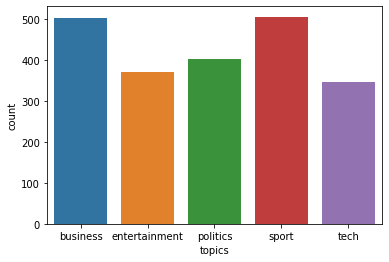

In [11]:
# countplot of 'topics'
sns.countplot(bbc['topics'], data=bbc)
plt.show()

In [14]:
# creating dulicate of dataset to bypass the long excecution time to import the dataset
bbc1=bbc.copy()

In [15]:
# changing 'news' column to string type
bbc1['news'] = bbc1['news'].astype('str') 

In [16]:
# first observation
bbc1.news[0]

'b\'India calls for fair trade rules\\n\\nIndia, which attends the G7 meeting of seven leading industrialised nations on Friday, is unlikely to be cowed by its newcomer status.\\n\\nIn London on Thursday ahead of the meeting, India\\\'s finance minister, lashed out at the restrictive trade policies of the G7 nations. He objected to subsidies on agriculture that make it hard for developing nations like India to compete. He also called for reform of the United Nations, the World Bank and the IMF.\\n\\nPalaniappan Chidambaram, India\\\'s finance minister, argued that these organisations need to take into account the changing world order, given India and China\\\'s integration into the global economy. He said the issue is not globalisation but "the terms of engagement in globalisation." Mr Chidambaram is attending the G7 meeting as part of the G20 group of nations, which account for two thirds of the world\\\'s population. At a conference on developing enterprise hosted by UK finance minis

In [18]:
# length of first observation
len(bbc1.news[0])

1938

## text pre-processing

In [22]:
# Remove HTML tags

In [20]:
def remove_html_tags(text):
	html_pattern = r'<.*?>'
	without_html = re.sub(pattern=html_pattern, repl=' ', string=text)
	return without_html

In [21]:
bbc1['news'] = bbc1['news'].apply(remove_html_tags)

In [23]:
# Remove urls

In [24]:
def remove_urls(text):
	url_pattern = r'https?://\S+|www\.\S+' 
	without_urls = re.sub(pattern=url_pattern, repl=' ', string=text)
	return without_urls

In [25]:
bbc1['news'] = bbc1['news'].apply(remove_urls)

In [26]:
bbc1.news[0]

'b\'India calls for fair trade rules\\n\\nIndia, which attends the G7 meeting of seven leading industrialised nations on Friday, is unlikely to be cowed by its newcomer status.\\n\\nIn London on Thursday ahead of the meeting, India\\\'s finance minister, lashed out at the restrictive trade policies of the G7 nations. He objected to subsidies on agriculture that make it hard for developing nations like India to compete. He also called for reform of the United Nations, the World Bank and the IMF.\\n\\nPalaniappan Chidambaram, India\\\'s finance minister, argued that these organisations need to take into account the changing world order, given India and China\\\'s integration into the global economy. He said the issue is not globalisation but "the terms of engagement in globalisation." Mr Chidambaram is attending the G7 meeting as part of the G20 group of nations, which account for two thirds of the world\\\'s population. At a conference on developing enterprise hosted by UK finance minis

In [27]:
# replacing every non-word characters with a white space 

In [28]:
for i in range(len(bbc1.news)):      
  bbc1.news[i] = re.sub(r"b\'", " ", bbc1.news[i]) 
  bbc1.news[i] = re.sub(r"\\\'", " ", bbc1.news[i])    
  bbc1.news[i] = re.sub(r"\\n\\n", " ", bbc1.news[i]) 
  bbc1.news[i] = re.sub(r"\\\'s", " ", bbc1.news[i]) 

In [29]:
bbc1.news[0]

' India calls for fair trade rules India, which attends the G7 meeting of seven leading industrialised nations on Friday, is unlikely to be cowed by its newcomer status. In London on Thursday ahead of the meeting, India s finance minister, lashed out at the restrictive trade policies of the G7 nations. He objected to subsidies on agriculture that make it hard for developing nations like India to compete. He also called for reform of the United Nations, the World Bank and the IMF. Palaniappan Chidambaram, India s finance minister, argued that these organisations need to take into account the changing world order, given India and China s integration into the global economy. He said the issue is not globalisation but "the terms of engagement in globalisation." Mr Chidambaram is attending the G7 meeting as part of the G20 group of nations, which account for two thirds of the world s population. At a conference on developing enterprise hosted by UK finance minister Gordon Brown on Friday, h

In [30]:
# Convert accented characters to ASCII characters

In [39]:
def accented_to_ascii(text):
	text = unidecode.unidecode(text)
	return text

In [40]:
bbc1['news'] = bbc1['news'].apply(accented_to_ascii)

In [41]:
# remove punctuations

In [42]:
def remove_punctuation(text):    
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

In [43]:
bbc1['news'] = bbc1['news'].apply(remove_punctuation)

In [44]:
# Remove numbers

In [45]:
def remove_numbers(text):
	number_pattern = r'\d+'
	without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
	return without_number

In [46]:
bbc1['news'] = bbc1['news'].apply(remove_numbers)

In [47]:
# Lowercase all texts

In [48]:
def lower_case_convertion(text):
	lower_text = text.lower()
	return lower_text

In [49]:
bbc1['news'] = bbc1['news'].apply(lower_case_convertion)

In [51]:
# Split attached words

In [52]:
def split_word(text):
  split = re.split("([A-Z][a-z]+[^A-Z]*)",text)
  return " ".join(split)

In [53]:
bbc1['news'] = bbc1['news'].apply(split_word)

In [54]:
# Removing short length words

In [55]:
bbc1['news'] = bbc1['news'].apply(lambda x: ' '.join([wds for wds in x.split() if len(wds)>1]))

In [56]:
# Remove extra whitespaces

In [57]:
def remove_extra_spaces(text):
	space_pattern = r'\s+'
	without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
	return without_space

In [58]:
bbc1['news'] = bbc1['news'].apply(remove_extra_spaces)

In [ ]:
# Standardizing and Spelling correction

In [59]:
def correction(text):
  standz = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text)) 
  spell = Speller(lang='en') 
  correct_spell=spell(standz) 
  return correct_spell

In [60]:
bbc1['news'] = bbc1['news'].apply(correction)

In [61]:
bbc1.news[0]

'india calls for fair trade rules india which attends the meeting of seven leading industrialised nations on friday is unlikely to be cowed by its newcomer status in london on thursday ahead of the meeting india finance minister lashed out at the restrictive trade policies of the nations he objected to subsidies on agriculture that make it hard for developing nations like india to compete he also called for reform of the united nations the world bank and the imf palaniappan chidambaram india finance minister argued that these organisations need to take into account the changing world order given india and china integration into the global economy he said the issue is not globalisation but the terms of engagement in globalisation mr chidambaram is attending the meeting as part of the group of nations which account for two thirds of the world population at conference on developing enterprise hosted by uk finance minister gordon brown on friday he said that he was in favour of floating ex

In [62]:
len(bbc1.news[0])

1816

In [ ]:
# Lemmatization

In [66]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text): 
	lemmas = [lemmatizer.lemmatize(wds, pos ='v') for wds in text.split()] 
	return " ".join(lemmas) 

In [67]:
bbc1['news'] = bbc1['news'].apply(lemmatize_word)

In [68]:
# remove stopwords

In [70]:
# list of stopwords from nltk
stopwords_nltk = list(stopwords.words('english'))

# list of stopwords from spacy
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)

# list of stopwords from gensim
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)
# all unique stop words
all_stopwords = list(set(all_stopwords))

def stop_words(text):  
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)

In [71]:
bbc1['news'] = bbc1['news'].apply(stop_words)

In [72]:
len(bbc1.news[0])

1173

In [ ]:
# remove frequent words

In [73]:
# list of frequent words
freq = pd.Series(' '.join(bbc1['news']).split()).value_counts()[:15]
freq

mr            2858
people        1889
new           1869
year          1722
game          1585
win           1461
time          1414
use           1398
xa            1335
xc            1331
come          1170
play          1158
world         1121
government    1118
film          1067
dtype: int64

In [75]:
# creating list of non-useful frequent words to remove from corpus
freq_words = ['mr','xa','xc','use','come','tell','year','month','time']

In [76]:
# removing non-useful frequent words
bbc1['news'] = bbc1['news'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_words))

In [81]:
# list of new frequent words in dataset
freq_new = pd.Series(' '.join(bbc1['news']).split()).value_counts()[:15]

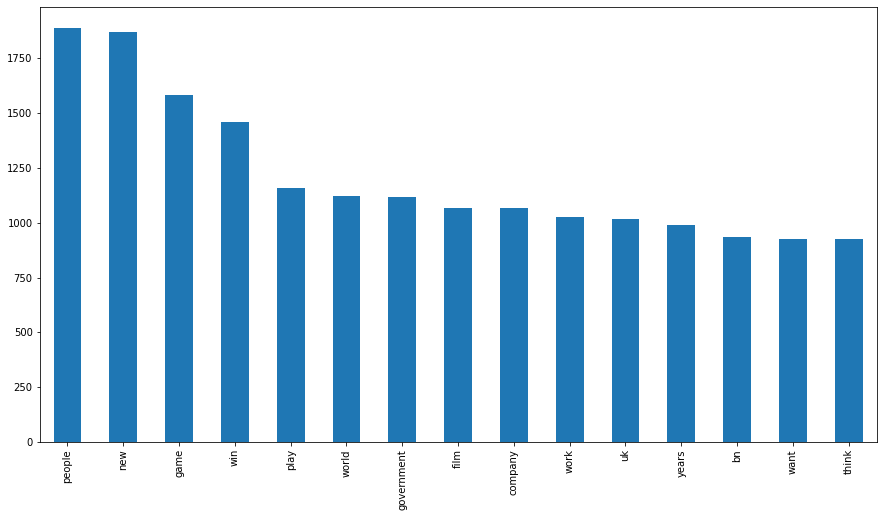

In [83]:
# bar plot of frequent words
plt.figure(figsize=(15,8))
freq_new.plot.bar()
plt.show()

In [77]:
# post cleaning first observation
bbc1.news[0]

'india fair trade rule india attend meet seven lead industrialise nations friday unlikely cow newcomer status london thursday ahead meet india finance minister lash restrictive trade policies nations object subsidies agriculture hard develop nations like india compete reform unite nations world bank imf palaniappan chidambaram india finance minister argue organisations need account change world order india china integration global economy issue globalisation term engagement globalisation chidambaram attend meet group nations account thirds world population conference develop enterprise host uk finance minister gordon brown friday favour float exchange rat help countries cope economic shock flexible exchange rate channel absorb positive negative shock conference india china brazil south africa russia invite meet place london friday saturday china expect face renew pressure abandon fix exchange rate nations particular blame surge cheap chinese export countries try fix exchange rat wish j

In [78]:
len(bbc1.news[0])

1148

## feature extraction

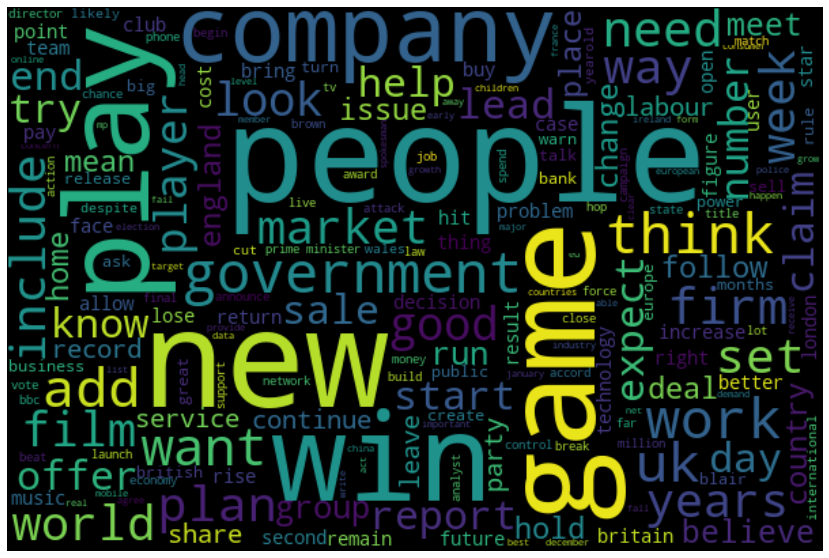

In [85]:
# wordcloud of all topics
plt.figure(figsize=(15,10))
allWords = ' '.join(bbc1['news'])
wordCloud = WordCloud(width=600, height=400, random_state=0, max_font_size=100).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [86]:
# now we will check for each topic what are the most frequent words, so that we can compare those words with our model generated 5 cluster/topics 

In [104]:
# frequent words for each topic
for i in bbc1.topics.unique():
  print(i)
  print('\n')
  print(pd.Series(' '.join(bbc1[bbc1['topics']==i]['news']).split()).value_counts()[:10])
  print('\n')

business


bn         772
company    620
firm       534
market     529
bank       451
rise       444
new        401
share      387
price      387
growth     358
dtype: int64


entertainment


film       909
best       563
award      510
music      421
star       398
win        375
new        315
include    310
years      238
band       227
dtype: int64


politics


labour        726
government    705
party         672
people        604
minister      540
blair         534
election      529
plan          469
new           419
brown         355
dtype: int64


sport


win        818
game       632
play       617
england    442
world      371
match      326
second     310
players    299
team       297
cup        291
dtype: int64


tech


game          839
people        828
phone         485
new           449
technology    449
mobile        419
service       417
users         343
net           328
firm          321
dtype: int64




In [105]:
# creating some new variables to analyze the data in detail

In [106]:
# length of articles

In [107]:
# creating 'length' column
bbc1['length']=bbc1['news'].apply(len)
bbc1.head()

news    topics  length
0  india fair trade rule india attend meet seven ...  business    1148
1  steel firm cut job mittal steel world largest ...  business     910
2  centre users lose patience customers try centr...  business    2023
3  ethiopia crop production ethiopia produce mill...  business     978
4  bsafety alert gm recall cars worlds biggest ca...  business    1140

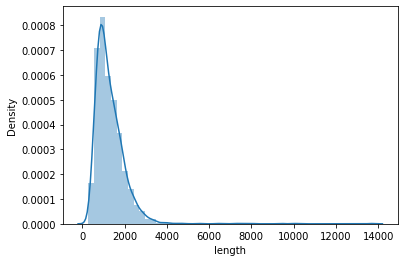

In [108]:
# distplot of 'length'
sns.distplot(bbc1['length'])
plt.show()

In [109]:
# most of the articles are of 0-4000 length

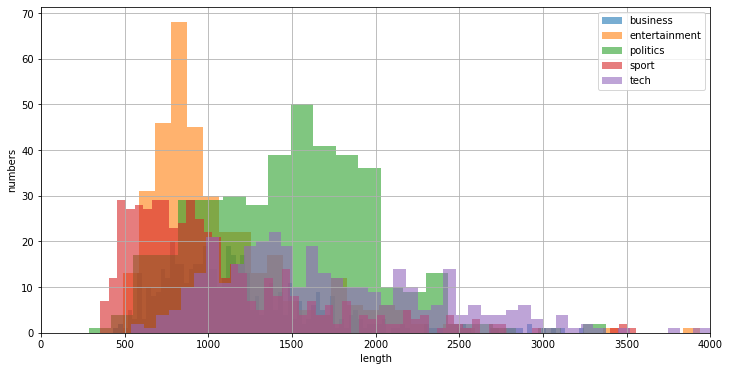

In [112]:
# histogram of all topic's length
bbc1_business = bbc1[bbc1['topics'] == 'business']
bbc1_entertainment = bbc1[bbc1['topics'] == 'entertainment']
bbc1_politics = bbc1[bbc1['topics'] == 'politics']
bbc1_sport = bbc1[bbc1['topics'] == 'sport']
bbc1_tech = bbc1[bbc1['topics'] == 'tech']

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['length'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['length'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['length'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['length'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['length'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,4000)
plt.grid()
plt.show()

In [113]:
# number of words

In [114]:
# creating 'word_count' column
bbc1['word_count'] = bbc1['news'].apply(lambda x: len(str(x).split(" ")))
bbc1.head()

news  ... word_count
0  india fair trade rule india attend meet seven ...  ...        156
1  steel firm cut job mittal steel world largest ...  ...        124
2  centre users lose patience customers try centr...  ...        277
3  ethiopia crop production ethiopia produce mill...  ...        124
4  bsafety alert gm recall cars worlds biggest ca...  ...        159

[5 rows x 4 columns]

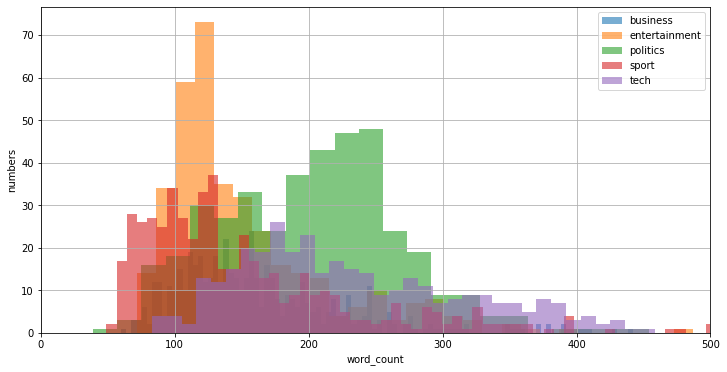

In [115]:
# histogram of all topic's word_count
bbc1_business = bbc1[bbc1['topics'] == 'business']
bbc1_entertainment = bbc1[bbc1['topics'] == 'entertainment']
bbc1_politics = bbc1[bbc1['topics'] == 'politics']
bbc1_sport = bbc1[bbc1['topics'] == 'sport']
bbc1_tech = bbc1[bbc1['topics'] == 'tech']

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['word_count'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['word_count'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['word_count'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['word_count'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['word_count'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('word_count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

In [ ]:
# Average Word Length

In [116]:
# creating 'avg_word' column
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))
bbc1['avg_word'] = bbc1['news'].apply(lambda x: avg_word(x))
bbc1.head()

news  ...  avg_word
0  india fair trade rule india attend meet seven ...  ...  6.365385
1  steel firm cut job mittal steel world largest ...  ...  6.346774
2  centre users lose patience customers try centr...  ...  6.306859
3  ethiopia crop production ethiopia produce mill...  ...  6.895161
4  bsafety alert gm recall cars worlds biggest ca...  ...  6.176101

[5 rows x 5 columns]

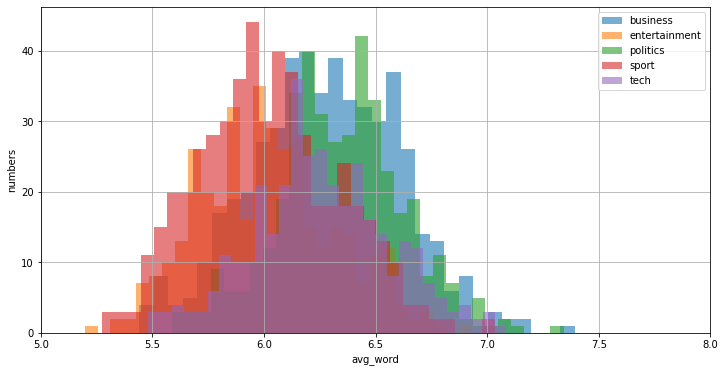

In [117]:
# histogram of all topic's avg_word
bbc1_business = bbc1[bbc1['topics'] == 'business']
bbc1_entertainment = bbc1[bbc1['topics'] == 'entertainment']
bbc1_politics = bbc1[bbc1['topics'] == 'politics']
bbc1_sport = bbc1[bbc1['topics'] == 'sport']
bbc1_tech = bbc1[bbc1['topics'] == 'tech']

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 30
plt.hist(bbc1_business['avg_word'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['avg_word'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['avg_word'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['avg_word'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['avg_word'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('avg_word')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(5,8)
plt.grid()
plt.show()

## Model building

In [ ]:
# vectorization

In [123]:
# using TF-IDF vectorizer 
vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 0.05)
small_document_term_matrix = vectorizer.fit_transform(bbc1['news'])

In [125]:
# sparse matrix size
small_document_term_matrix.shape

(2127, 513)

#### Latent Dirichlet allocation (LDA)

In [201]:
# LDA model
lda = LatentDirichletAllocation(n_components=5, max_iter=1000, random_state=0, n_jobs=-1)
lda.fit(small_document_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=1000,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [204]:
# visualization of LDA model using pyLDAvis
lda_panel = pyLDAvis.sklearn.prepare(lda, small_document_term_matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  33.324514
4       51.163364 -159.968018       2        1  31.059442
0      -73.144554   21.523815       3        1  21.824089
2      -66.410133 -110.606438       4        1  10.775759
3       54.417324   12.443444       5        1   3.016196, topic_info=        Term       Freq      Total Category  logprob  loglift
48        bn  63.000000  63.000000  Default  30.0000  30.0000
198   growth  34.000000  34.000000  Default  29.0000  29.0000
393     rise  42.000000  42.000000  Default  28.0000  28.0000
33      bank  41.000000  41.000000  Default  27.0000  27.0000
351    price  39.000000  39.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
37      beat   0.701709  26.460397   Topic5  -6.2395  -0.1287
315  operate   0.701695  13.920621   Topic5  -6.2395   0.5135
208   higher   0.701691  16.324900   Topic5  -6.2395   0.3542
378  receive   0.701676  22.157546   Topic5  -6.2395   0.0487
477    trade   0.701668  29.929522   Topic5  -6.2395  -0.2520

[255 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.230368   accept
1         2  0.307157   accept
1         3  0.383947   accept
1         5  0.076789   accept
2         2  0.699577   access
...     ...       ...      ...
508       5  0.082211    wrong
509       1  0.875332  yearold
509       2  0.076116  yearold
509       3  0.038058  yearold
509       5  0.038058  yearold

[778 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])

In [205]:
# checking top 15 words for each of our LDA topics 
terms_lda = vectorizer.get_feature_names()

for i, comp in enumerate(lda.components_):
  terms_comp = zip(terms_lda, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
  print("topic "+str(i)+": ")
  for t in sorted_words:
      print(t[0],end=" ")
  print("\n")

topic 0: 
labour party government blair minister election brown people plan tax howard prime secretary public tory 

topic 1: 
win film play game award best star england club match world second cup champion team 

topic 2: 
rise growth economy bn price bank sales economic profit market figure fall rat quarter trade 

topic 3: 
security fourth file online giant legal football net information council saturday program development estimate finish 

topic 4: 
company firm people bn new phone market share technology service music game mobile sell offer 



In [206]:
# creating function for wordcloud of LDA topics
def draw_word_cloud_lda(index):
  imp_words_topic=""
  comp=lda.components_[index]
  terms_comp = zip(terms_lda, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [207]:
# wordcloud of LDA topics

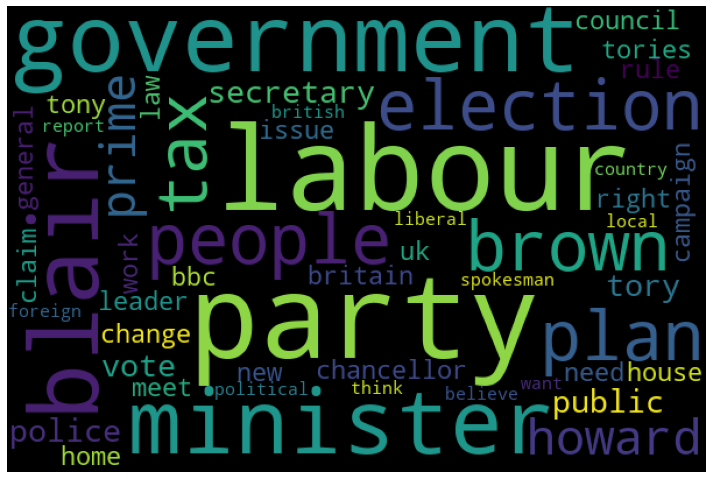

In [208]:
draw_word_cloud_lda(0)

In [209]:
# we can classify this topic as 'politics'

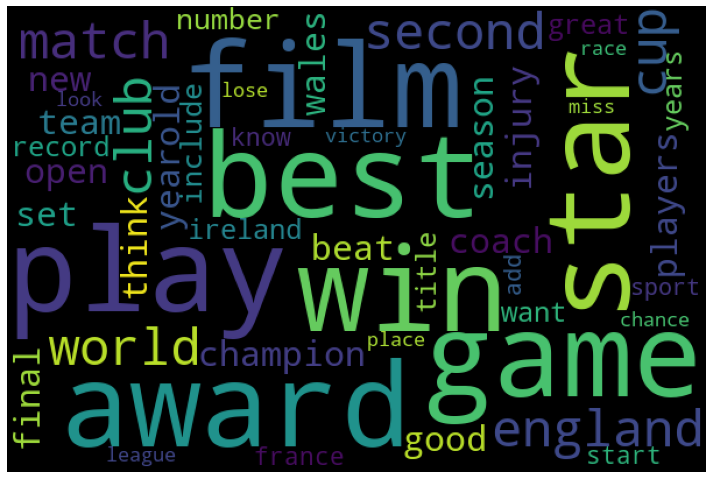

In [210]:
draw_word_cloud_lda(1)

In [211]:
# we cannot classify this topic as single toipcs. it seems mix of 'sport' and 'entertainment'

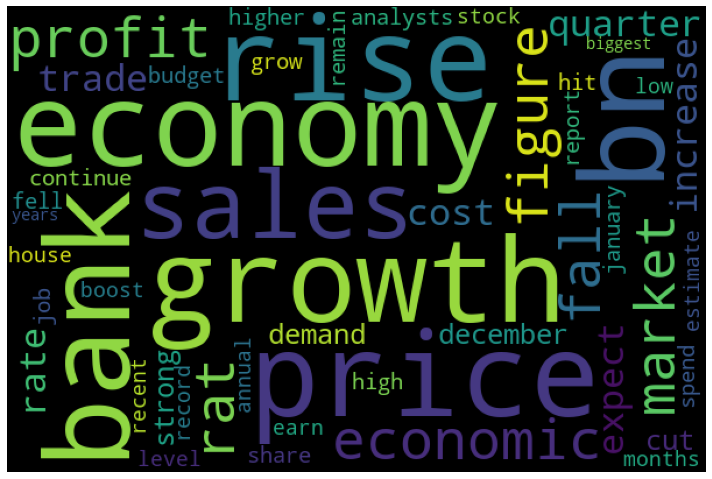

In [212]:
draw_word_cloud_lda(2)

In [213]:
# we can classify this topic as 'business'

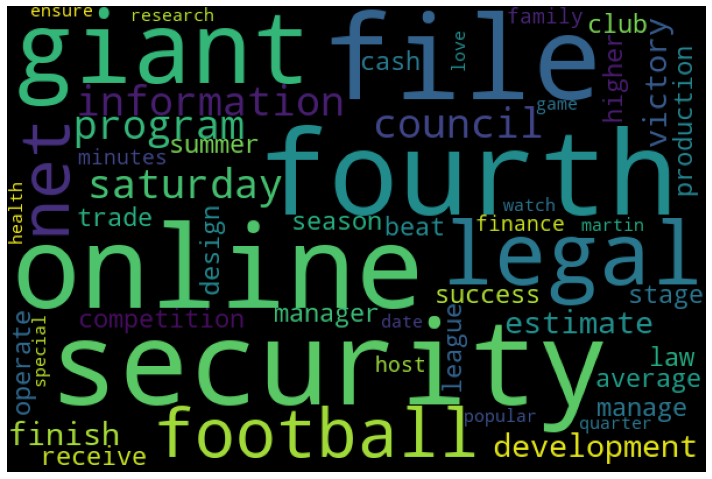

In [214]:
draw_word_cloud_lda(3)

In [217]:
# we can classify this topic as 'tech' topic

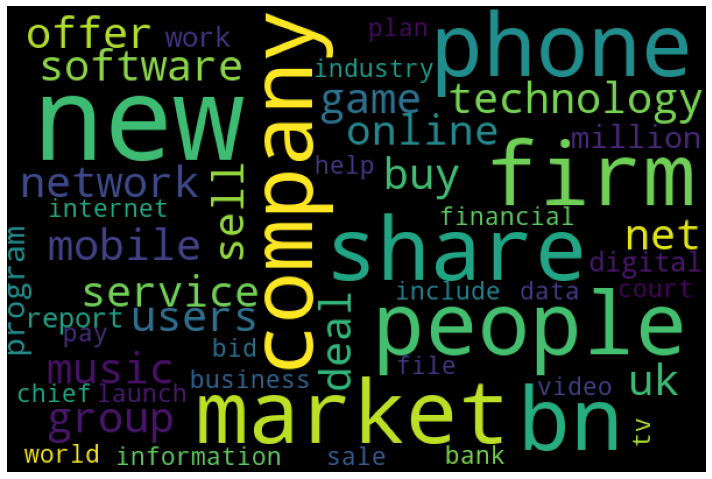

In [218]:
draw_word_cloud_lda(4)

In [219]:
# we cannot classify this as a single topic, it is mix topic

In [220]:
# summary of LDA model

In [221]:
# model able to correctly classify 3 topics i.e politics, business and tech
# for other two clusters it was unable to classify the clusters as entertainment and sports

#### Latent Semantic Analysis (LSA)

In [222]:
# LSA model
svd = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=1000, random_state=0)
svd.fit(small_document_term_matrix)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=1000,
             random_state=0, tol=0.0)

In [223]:
# pyLDAvis does not sport LSA(sklearn), so we will evaluate model performance through t-SNE Clustering

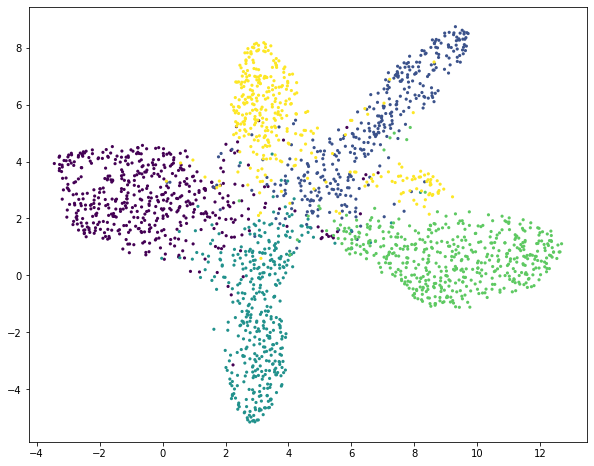

In [224]:
# visualization of LSA model using t-SNE Clustering
all_topics = svd.fit_transform(small_document_term_matrix)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=0).fit_transform(all_topics)
bbc1['target'] = pd.factorize(bbc1['topics'])[0] + 1

plt.figure(figsize=(10,8))
plt.scatter(embedding[:, 0], embedding[:, 1], c = bbc1.target, s = 10, edgecolor='none')
plt.show()

In [225]:
# checking top 15 words for each of our LSA topics 
terms_lsa = vectorizer.get_feature_names()
for i, comp in enumerate(svd.components_):
  terms_comp = zip(terms_lsa, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
  print("topic "+str(i)+": ")
  for t in sorted_words:
      print(t[0],end=" ")
  print("\n")

topic 0: 
game win film new people play bn company world government firm uk work best market 

topic 1: 
game film win play award best england star match cup players champion beat team injury 

topic 2: 
film award best star director include tv music screen company bn million box sales release 

topic 3: 
labour party blair election film brown howard minister prime tory government award tax tories campaign 

topic 4: 
phone people mobile technology users music game service software program digital network net tv online 



In [226]:
# creating function for wordcloud of LSA topics
def draw_word_cloud_lsa(index):
  imp_words_topic=""
  comp=svd.components_[index]
  terms_comp = zip(terms_lsa, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [245]:
# wordcloud of LSA topics

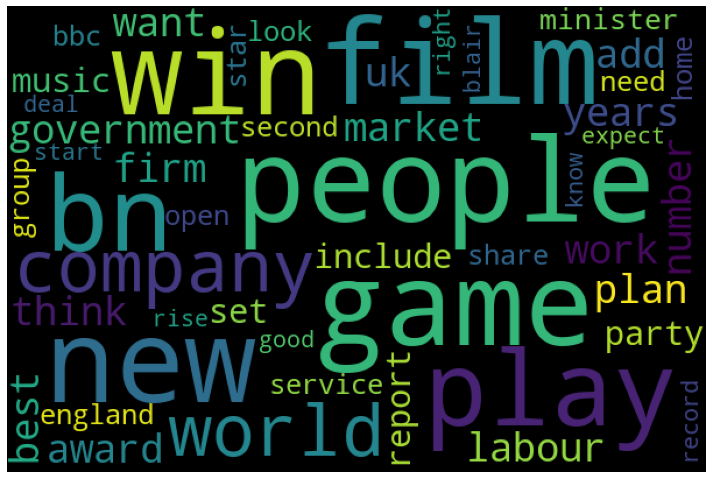

In [227]:
draw_word_cloud_lsa(0)

In [243]:
# predominantly the cluster is showing as 'business' topic, but we can not surely classify this as 'business' topic. It is a mix topic.
# the fact can again be justified from the t-SNE Clustering above, where we can see the 'yellow' cluster is not well defined.

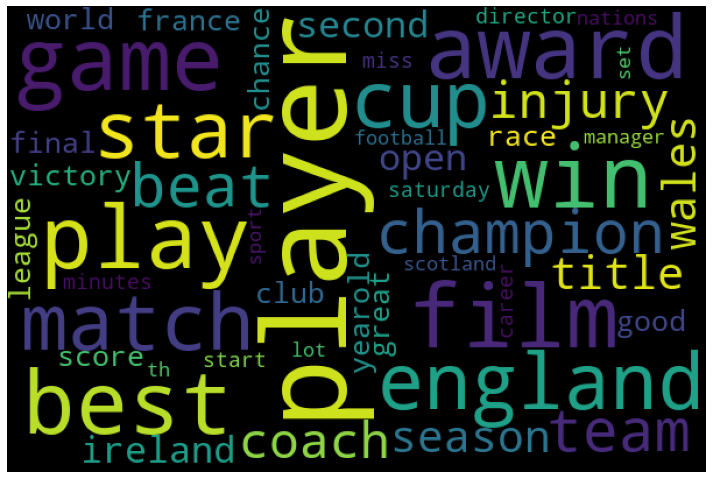

In [228]:
draw_word_cloud_lsa(1)

In [232]:
# we can classify this topic as 'sport'

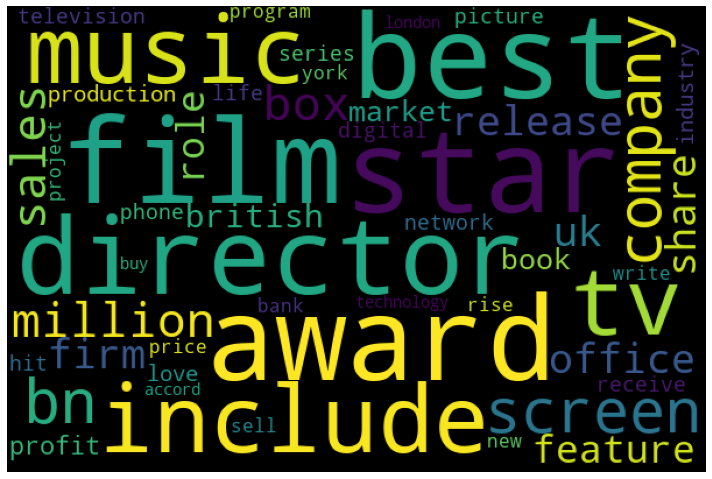

In [229]:
draw_word_cloud_lsa(2)

In [233]:
# we can classify this topic as 'entertainment'

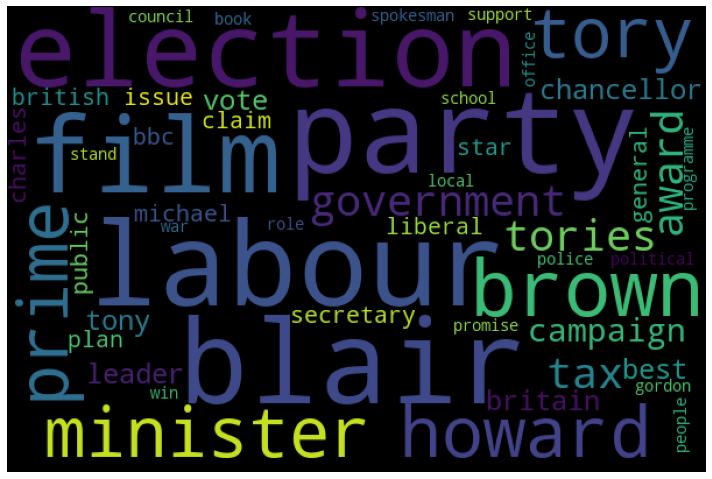

In [230]:
draw_word_cloud_lsa(3)

In [234]:
# we can classify this topic as 'politics'

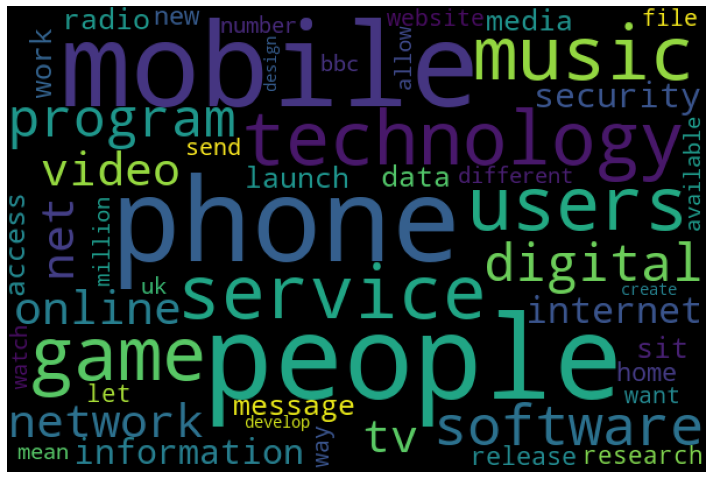

In [231]:
draw_word_cloud_lsa(4)

In [235]:
# we can classify this topic as 'tech'

In [242]:
# summary of LSA model

In [244]:
# model able to correctly classify 4 topics i.e sports, entertainment, politics and tech
# model was unable to classify the topic 'business' properly

#### Non-negative matrix factorization (NMF)

In [182]:
# NMF model
nmf = NMF(n_components=5, max_iter=1000)
nmf.fit(small_document_term_matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=1000,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [183]:
# visualization of NMF model using pyLDAvis
nmf_panel = pyLDAvis.sklearn.prepare(nmf, small_document_term_matrix,vectorizer,mds='tsne')
nmf_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  25.286958
4       51.163364 -159.968018       2        1  22.890497
0      -73.144554   21.523815       3        1  21.450936
3      -66.410133 -110.606438       4        1  19.428842
2       54.417324   12.443444       5        1  10.942767, topic_info=        Term        Freq       Total Category  logprob  loglift
167     film  123.000000  123.000000  Default  30.0000  30.0000
31     award   68.000000   68.000000  Default  29.0000  29.0000
41      best   66.000000   66.000000  Default  28.0000  28.0000
240   labour   66.000000   66.000000  Default  27.0000  27.0000
48        bn   67.000000   67.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
483       uk    9.727297   54.874287   Topic5  -4.8990   0.4824
290  million    8.421270   36.867374   Topic5  -5.0431   0.7359
333     play    9.370956   71.748816   Topic5  -4.9363   0.1769
304      new    9.216013   75.535669   Topic5  -4.9530   0.1088
265   london    7.748047   30.152159   Topic5  -5.1265   0.8537

[235 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         2  0.936833   access
2         4  0.052046   access
4         2  0.175133  account
4         3  0.758910  account
4         4  0.058378  account
...     ...       ...      ...
510       1  0.269930    years
510       2  0.166111    years
510       3  0.249166    years
510       4  0.124583    years
510       5  0.207639    years

[546 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

In [237]:
# checking top 15 words for each of our NMF topics 
terms_nmf = vectorizer.get_feature_names()
for i, comp in enumerate(nmf.components_):
  terms_comp = zip(terms_nmf, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
  print("topic "+str(i)+": ")
  for t in sorted_words:
      print(t[0],end=" ")
  print("\n")

topic 0: 
bn company firm bank market share rise price sales growth profit economy deal economic trade 

topic 1: 
game win play england match cup players team wales champion club coach world ireland injury 

topic 2: 
film award best star win director include british tv screen role box book release office 

topic 3: 
labour party blair election government minister brown tax howard prime tory plan tories campaign chancellor 

topic 4: 
people phone music technology mobile service users net software network digital program new tv internet 



In [185]:
# creating function for wordcloud of NMF topics
def draw_word_cloud_nmf(index):
  imp_words_topic=""
  comp=nmf.components_[index]
  terms_comp = zip(terms_nmf, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [191]:
# wordcloud of NMF topics

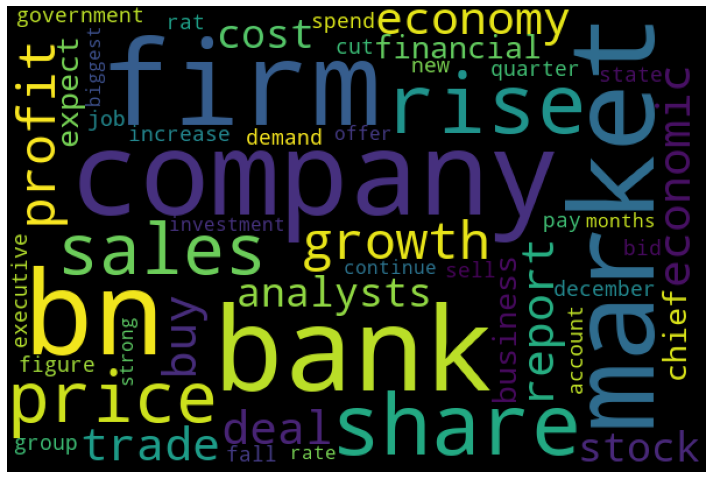

In [186]:
draw_word_cloud_nmf(0)

In [192]:
# we can classify this topic as 'business'

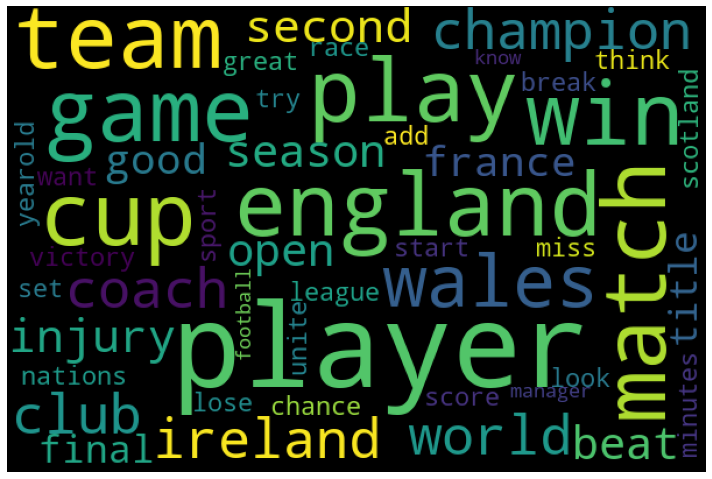

In [187]:
draw_word_cloud_nmf(1)

In [193]:
# we can classify this topic as 'sport'

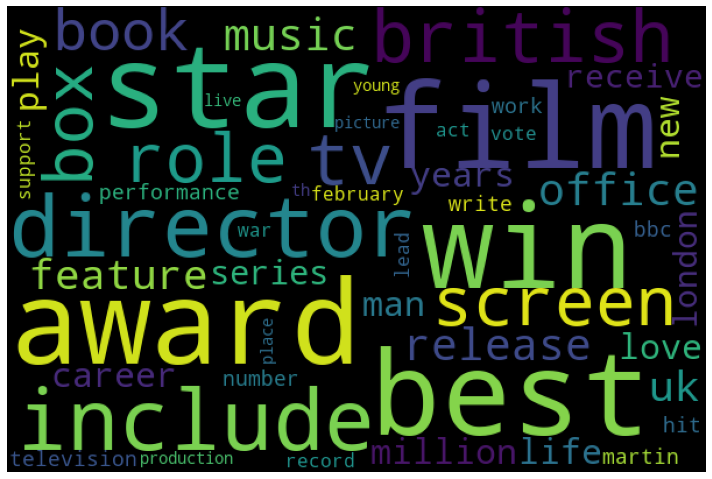

In [188]:
draw_word_cloud_nmf(2)

In [194]:
# we can classify this topic as 'entertainment'

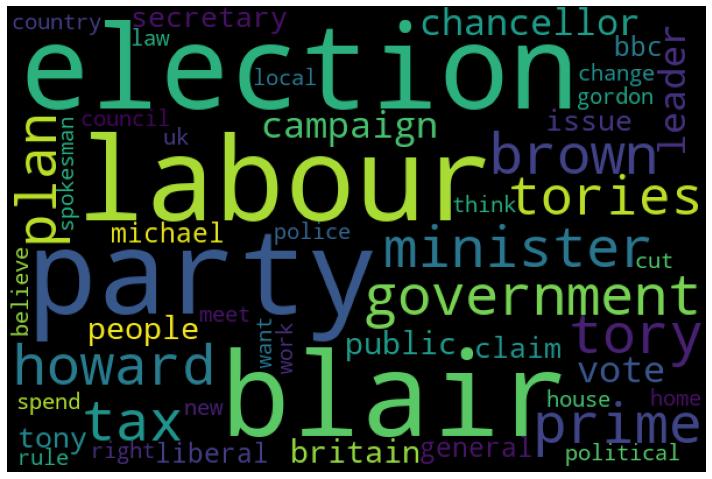

In [189]:
draw_word_cloud_nmf(3)

In [195]:
# we can classify this topic as 'politics'

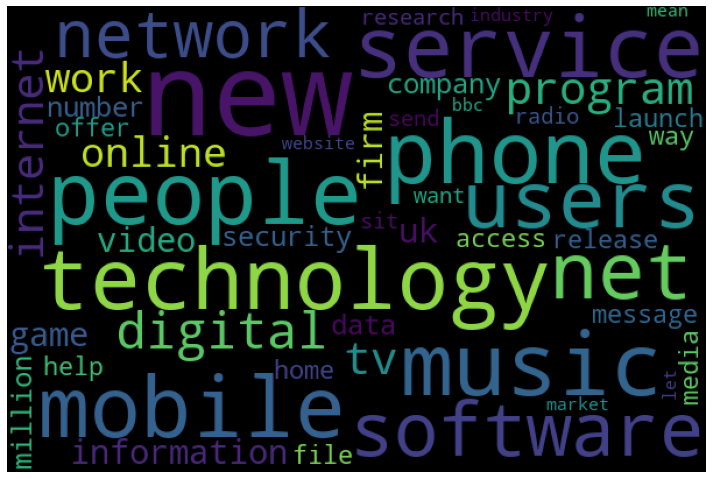

In [190]:
draw_word_cloud_nmf(4)

In [196]:
# we can classify this topic as 'tech'

In [202]:
# summary of NMF model

In [246]:
# model was able to correctly classify all the topics

## Conclusion

*   NMF with TF-IDF vectorizer was the best model to identify the topics properly for our dataset
*   Scope of implementing LSA using genism library and neural network with word2vec in future